 ## EE 228 HW1

### Name: Tianzi Luo
### Student ID: 862251424

## Q1 download and formatting the data

In [1]:
# import library
## python 3.x is requirment
try:
    import urllib.request
except ImportError:
    raise ImportError('You should use Python 3.x')
import os.path  ##OS library
import gzip    ##Operate the compressed package
import pickle
import os
import numpy as np
import time
from datetime import datetime
import matplotlib.pyplot as plt.

In [2]:
## Dictionary
### tags and corresponding files
url_base = 'http://yann.lecun.com/exdb/mnist/'
key_file = {
    'train_img':'train-images-idx3-ubyte.gz',
    'train_label':'train-labels-idx1-ubyte.gz',
    'test_img':'t10k-images-idx3-ubyte.gz',
    'test_label':'t10k-labels-idx1-ubyte.gz',
}

## Download to current directory
dataset_dir = os.path.dirname('./')

## The folder needs to be downloaded to which directory
save_file = dataset_dir + "/mnist.pkl"

## Dataset Information
train_num = 60000
test_num = 10000
img_dim = (1, 28, 28)
img_size = 784

In [3]:
## Download function
def _download(file_name):
    file_path = dataset_dir + "/" + file_name ##The path where the file is located

    if os.path.exists(file_path):            ##Check if the path exists
        return

    print("Downloading " + file_name + " ... ")
    urllib.request.urlretrieve(url_base + file_name,file_path)   ## Download path, file's name, file's directory
    print("Done")

In [4]:
## Map the compressed package to each tag('train_img','train_label','test_img','test_label') and download.('key_file')
def download_mnist():
    for v in key_file.values():   
       _download(v)

In [5]:
## Download the label
### Similar with download function
def _load_label(file_name):
    file_path = dataset_dir + "/" + file_name   ##The path where the file is located

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            labels = np.frombuffer(f.read(), np.uint8, offset=8)  ## open the gz file and read it, save as uint8, offset=8 (convert)
    print("Done")

    return labels
## return labels

In [6]:
## Load image
### Similar with previous function
def _load_img(file_name):
    file_path = dataset_dir + "/" + file_name

    print("Converting " + file_name + " to NumPy Array ...")
    with gzip.open(file_path, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
    data = data.reshape(-1, img_size)   ## reshape data size
    print("Done")

    return data
## return data

In [7]:
def _convert_numpy():
    dataset = {}
    dataset['train_img'] =  _load_img(key_file['train_img'])  ##train-images-idx3-ubyte.gz
    dataset['train_label'] = _load_label(key_file['train_label'])  ##'train-labels-idx1-ubyte.gz'
    dataset['test_img'] = _load_img(key_file['test_img'])     ##'t10k-images-idx3-ubyte.gz'
    dataset['test_label'] = _load_label(key_file['test_label'])   ##'t10k-labels-idx1-ubyte.gz'
                   
    return dataset

In [8]:
## Initialization
def init_mnist():
    download_mnist()           ## download data
    dataset = _convert_numpy()  ##convert deta
    print("Creating pickle file ...")
    with open(save_file, 'wb') as f:
        pickle.dump(dataset, f, -1)
    print("Done!")

In [9]:
##  Convert to one-hot encoding
### 0,1 two states
def _change_one_hot_label(X):
    T = np.zeros((X.size, 10))
    for idx, row in enumerate(T):
        row[X[idx]] = 1.0

    return T
## eg.2=[0，0，1，0，0，0，0，0，0，0]

In [10]:
## Judgment normalization，flatten and one-hot state.
def load_mnist(normalize=True, flatten=True, one_hot_label=True):

    if not os.path.exists(save_file):
        init_mnist()

    with open(save_file, 'rb') as f:
        dataset = pickle.load(f)

    if normalize:
        for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].astype(np.float32)
            dataset[key] /= 255.0

    if one_hot_label:
        dataset['train_label'] = _change_one_hot_label(dataset['train_label'])
        dataset['test_label'] = _change_one_hot_label(dataset['test_label'])

    if not flatten:
         for key in ('train_img', 'test_img'):
            dataset[key] = dataset[key].reshape(-1, 1, 28, 28)

    return (dataset['train_img'], dataset['train_label']), (dataset['test_img'], dataset['test_label'])

In [11]:
 init_mnist()

Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [12]:
(train_image, train_label), (test_x, test_y)=load_mnist()
print("train image shape", train_image.shape)
print("train label shape", train_label.shape)
print("test image shape", test_x.shape)
print("test label shape", test_y.shape)

train image shape (60000, 784)
train label shape (60000, 10)
test image shape (10000, 784)
test label shape (10000, 10)


In [13]:
#create reainning set and validation set
train_x = train_image[0:50000]
validation_x = train_image[50000:60000]
train_y = train_label[0:50000]
validation_y= train_label[50000:60000]

print("train set shape", train_x.shape)
print("train label shape", train_y.shape)
print("validation image shape", validation_x.shape)
print("validation label shape", validation_y.shape)
print("test image shape", test_x.shape)
print("test label shape", test_y.shape)

train set shape (50000, 784)
train label shape (50000, 10)
validation image shape (10000, 784)
validation label shape (10000, 10)
test image shape (10000, 784)
test label shape (10000, 10)


In [14]:
# print(train_y.shape[0])
# print(test_y.shape[1])
#print(1000/150) ## always float
#print(1000//150)  ##integer

## Q2. SGD function

In [15]:
# minibatch sgd
def minibatch_SGD(B, itrs, eta, train_x, train_y, test_x, test_y):
    loss = []
    cal_itr = []
    correspond_acc = []
    itr_batch = itrs//100
    W = np.zeros((784,10), dtype=np.float32)
    for i in range(itrs):
        if i % itr_batch == 0:
            cal_itr.append(i)
            correspond_acc.append(test(W,validation_x,validation_y))
        ## if i % 250 == 0:
        ## print("Num iters: {}".format(i))
        # select batch
        r = np.random.choice(train_x.shape[0], size=B, replace=True)
        X = train_x[r]
        Y = train_y[r]
       ##  print(X.shape)
       ##  print(Y.shape)
        g = X.T.dot(X.dot(W)) - X.T.dot(Y) ##gradient
        g = 1/B*g
        W = W-eta*(g)
        loss.append(0.5*(np.linalg.norm(Y - X.dot(W))**2)/B)
         
    return W,loss,cal_itr,correspond_acc

def test(W,test_x,test_y):
    
    count = 0 
    y_hat = test_x@W
#     for i in range (test_x.shape[0]):
#         y_hat = np.argmax(test_x@W, axis=1)
#         ((np.argmax(test_x@W, axis=1) == np.argmax(test_y,axis=1)).sum() /test_y.shape[0])
#         corr = y_hat == np.argmax(test_y,axis=1).

    for i in range(test_x.shape[0]):
        if (np.argmax(y_hat[i]))==(np.argmax(test_y[i])):
            count += 1
    acc = count / test_y.shape[0]
            
      #  print(y_hat)
    return acc

In [16]:
def plot_curve(loss_curve):
    plt.title("Training Loss VS Iteration")
    plt.ylabel('Training Loss')
    plt.xlabel('Iterations')
    plt.plot(loss_curve, linewidth=0.5, color = 'red')
    plt.show()

In [17]:
def plot_acc(cal_itr,correspond_acc):
    plt.title("Test Accuracy VS Iteration")
    plt.ylabel('Accuracy')
    plt.xlabel('Iterations') 
    plt.plot(cal_itr,correspond_acc,linewidth=0.5, color = 'blue')
    plt.show()

## Q3 The role of batch size

### a.B=1, determine learning rate & iterations

##### 1）When B=1, iteration=100, learning rate=0.0001,the result shows below：

--- 6.371381044387817 seconds ---


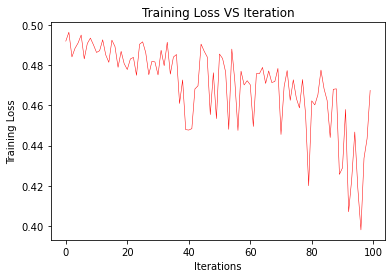

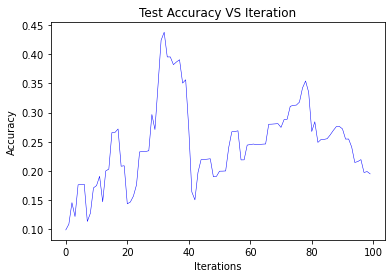

In [18]:
## B=1,Iteration=100, learning rate(eta)=0.0001
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(1,100,0.0001,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

##### 2）When B=1, iteration=10000, learning rate=0.0001,the result shows below：
It seems that the training loss reduces and the accuracy increases.

--- 7.043592214584351 seconds ---


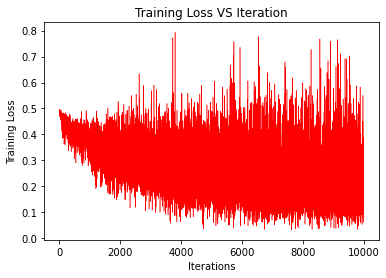

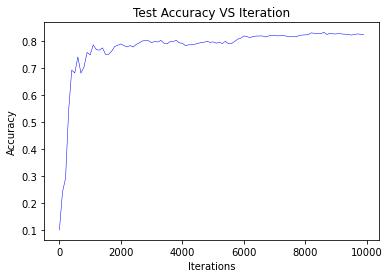

In [19]:
## B=1,Iteration=10000, learning rate(eta)=0.0001
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(1,10000,0.0001,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

##### 3）When B=1, iteration=10000, learning rate=0.01,the result shows below：
It seems that the results beco more stable.

--- 6.988566637039185 seconds ---


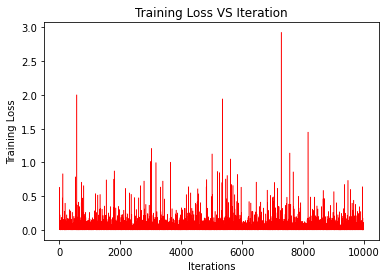

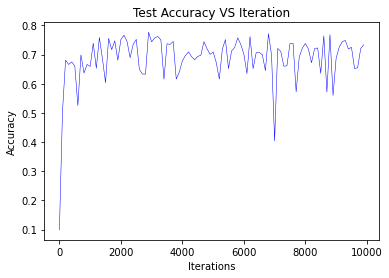

In [20]:
## B=1,Iteration=10000, learning rate(eta)=0.01
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(1,10000,0.01,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

### b. B=10, determine learning rate & iterations

##### 1) When B=10, iteration=100, learning rate=0.0001,the result shows below：

--- 6.371448755264282 seconds ---


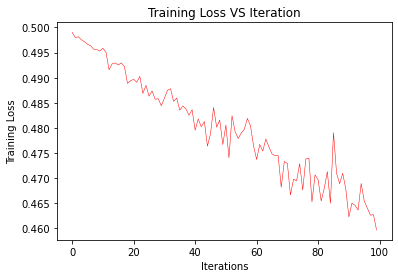

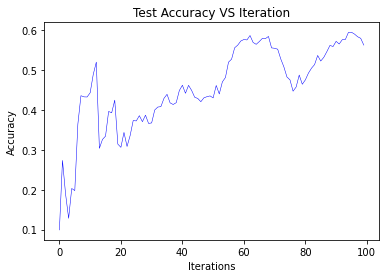

In [21]:
## B=10,Iteration=100, learning rate(eta)=0.0001
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(10,100,0.0001,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

##### 2）When B=10, iteration=10000, learning rate=0.0001,the result shows below：

--- 7.489700078964233 seconds ---


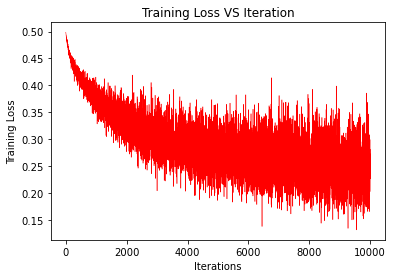

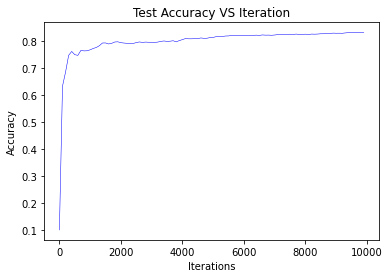

In [22]:
## B=10,Iteration=10000, learning rate(eta)=0.0001
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(10,10000,0.0001,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

##### 3） When B=10, iteration=10000, learning rate=0.01,the result shows below：

--- 7.483699083328247 seconds ---


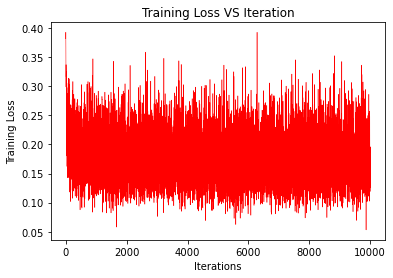

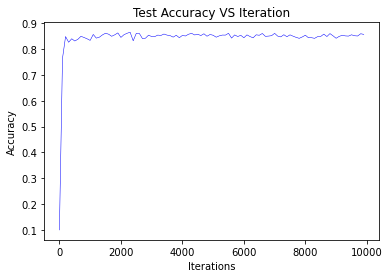

In [23]:
## B=10,Iteration=10000, learning rate(eta)=0.01
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(10,10000,0.01,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

### c. B=100, determine learning rate & iterations

##### 1）When B=100, iteration=100, learning rate=0.001,the result shows below：

--- 6.555780649185181 seconds ---


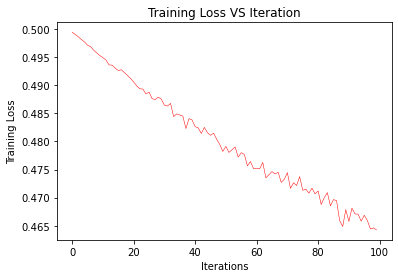

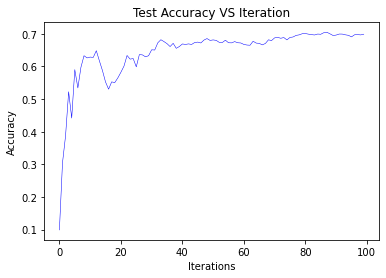

In [24]:
## B=100,Iteration=100, learning rate(eta)=0.0001
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(100,100,0.0001,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

##### 2）When B=100, iteration=10000, learning rate=0.0001,the result shows below：

--- 17.0068302154541 seconds ---


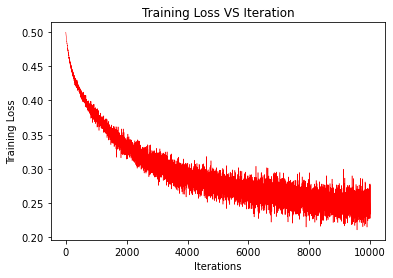

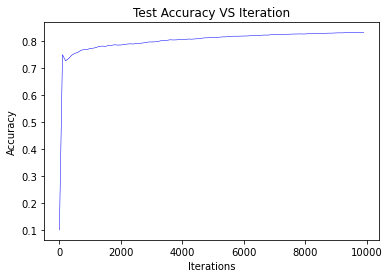

In [25]:
## B=100,Iteration=10000, learning rate(eta)=0.0001
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(100,10000,0.0001,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

##### 3）When B=100, iteration=10000, learning rate=0.01,the result shows below：

--- 16.914649724960327 seconds ---


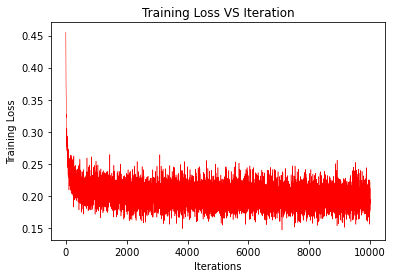

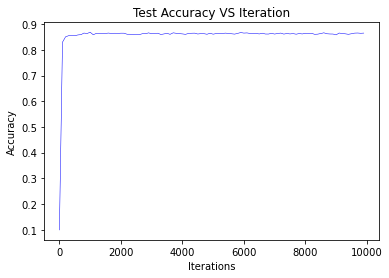

In [26]:
## B=100,Iteration=10000, learning rate(eta)=0.01
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(100,10000,0.01,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

### d.B=1000, determine learning rate & iterations

##### 1）When B=1000, iteration=100, learning rate=0.0001,the result shows below：

--- 7.376863718032837 seconds ---


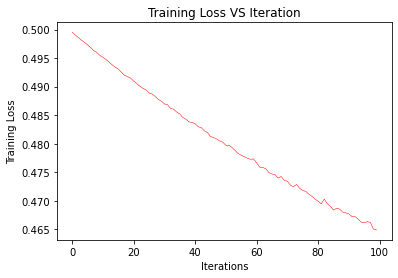

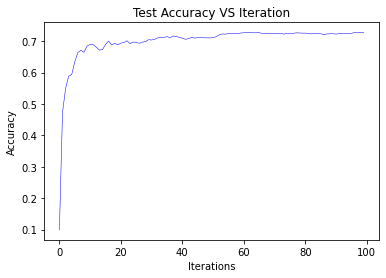

In [27]:
## B=1000,Iteration=100, learning rate(eta)=0.0001
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(1000,100,0.0001,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

##### 2）When B=1000, iteration=10000, learning rate=0.0001,the result shows below：

--- 106.21946954727173 seconds ---


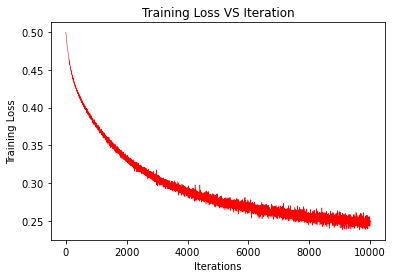

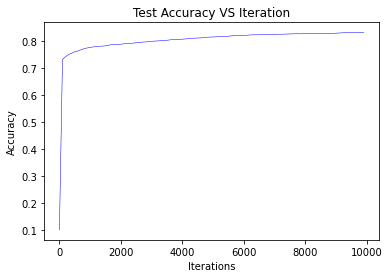

In [28]:
## B=1000,Iteration=10000, learning rate(eta)=0.0001
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(1000,10000,0.0001,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

##### 3）When B=1000, iteration=10000, learning rate=0.01,the result shows below：

--- 106.7957124710083 seconds ---


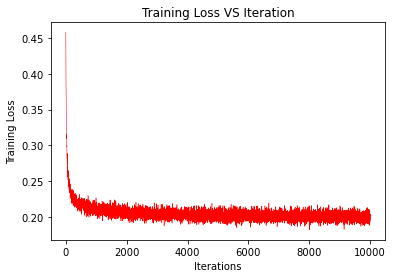

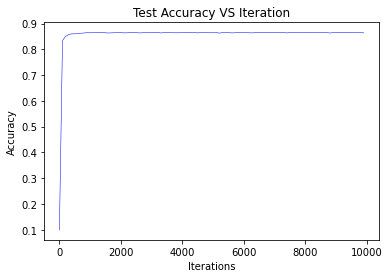

In [29]:
## B=1000,Iteration=10000, learning rate(eta)=0.01
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(1000,10000,0.01,train_x, train_y, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

## Q5 The role of training dataset size

#### a.When datasize=100,B=100,learning rate=0.001,iteration=10000

--- 16.932878017425537 seconds ---


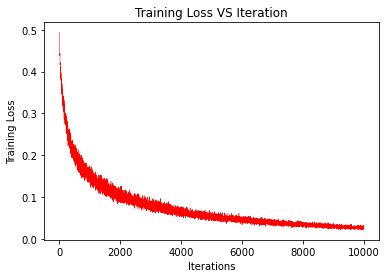

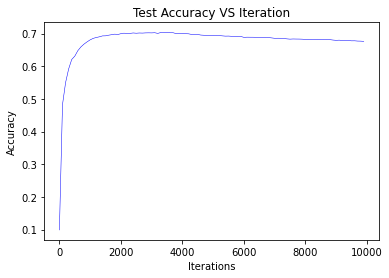

In [30]:
k1 = np.random.choice(train_x.shape[0], size=100, replace=False)
X1 = train_x[k1]
Y1 = train_y[k1]

## B=100,Iteration=10000,learning rate(eta)=0.001,data size=100
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(100,10000,0.001,X1, Y1, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

#### b.When datasize=500,B=100,learning rate=0.001,iteration=10000

--- 17.376596689224243 seconds ---


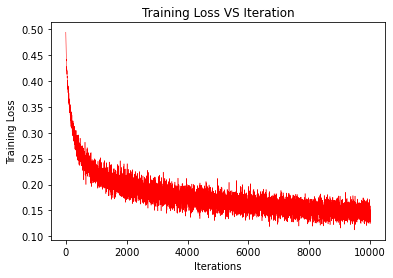

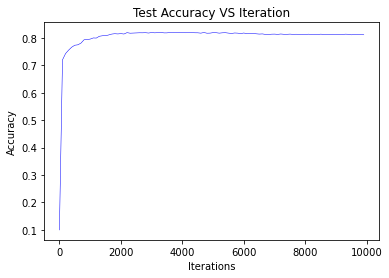

In [31]:
k2 = np.random.choice(train_x.shape[0], size=500, replace=False)
X2 = train_x[k2]
Y2 = train_y[k2]

## B=100,Iteration=10000,learning rate(eta)=0.001,data size=100
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(100,10000,0.001,X2, Y2, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

#### c.When datasize=1000,B=100,learning rate=0.001,iteration=10000

--- 18.76704740524292 seconds ---


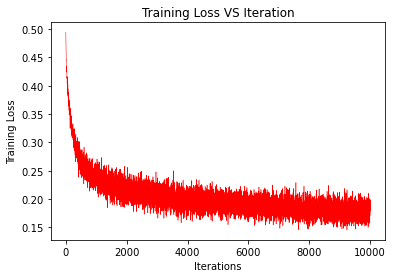

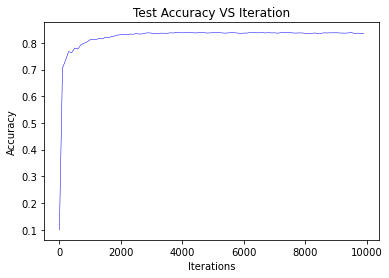

In [32]:
k3 = np.random.choice(train_x.shape[0], size=1000, replace=False)
X3 = train_x[k3]
Y3 = train_y[k3]

## B=100,Iteration=10000,learning rate(eta)=0.001,data size=100
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(100,10000,0.001,X3, Y3, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
## print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)

#### d.When datasize=10000,B=100,learning rate=0.001,iteration=10000

--- 16.889658451080322 seconds ---


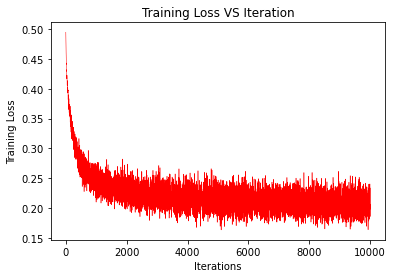

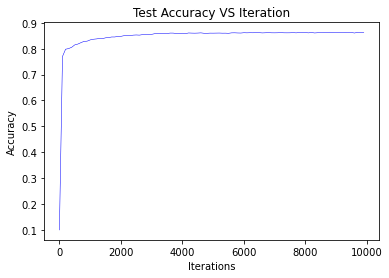

In [36]:
k4 = np.random.choice(train_x.shape[0], size=10000, replace=False)
X4 = train_x[k4]
Y4 = train_y[k4]

## B=100,Iteration=10000,learning rate(eta)=0.001,data size=100
start_time = time.time()
(W,loss,cal_itr,correspond_acc) = minibatch_SGD(100,10000,0.001,X4, Y4, test_x, test_y) 
print("--- %s seconds ---" % (time.time() - start_time)) 
#print(loss)  
plot_curve(loss)
plot_acc(cal_itr,correspond_acc)
